# IMPORTING LIBRARIES

In [102]:
import numpy as np 
import pandas as pd 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, optimizers
import seaborn as sns
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense


# VARIABLE DECLARATION

In [57]:
img_size=256
Batch_size=32
CHANNELS=3
EPOCHS = 100

# IMPORTING DATASET INTO TENSORFLOW DATA OBJECT

In [58]:
# LOADING THE DATASET
dataset=tf.keras.preprocessing.image_dataset_from_directory(
   "PlantVillage",
    shuffle=True,
    image_size=(img_size,img_size),
    batch_size=Batch_size
)


Found 2152 files belonging to 3 classes.


In [59]:
# DISPLAYING CLASS NAMES
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [60]:
len(dataset)

68

In [61]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[160. 157. 166.]
  [157. 154. 163.]
  [141. 138. 147.]
  ...
  [140. 137. 148.]
  [116. 113. 124.]
  [122. 119. 130.]]

 [[159. 156. 165.]
  [166. 163. 172.]
  [156. 153. 162.]
  ...
  [124. 121. 132.]
  [132. 129. 140.]
  [134. 131. 142.]]

 [[141. 138. 147.]
  [150. 147. 156.]
  [146. 143. 152.]
  ...
  [130. 127. 138.]
  [138. 135. 146.]
  [135. 132. 143.]]

 ...

 [[193. 190. 201.]
  [188. 185. 196.]
  [194. 191. 202.]
  ...
  [156. 153. 164.]
  [164. 161. 172.]
  [171. 168. 179.]]

 [[169. 166. 177.]
  [170. 167. 178.]
  [182. 179. 190.]
  ...
  [157. 154. 165.]
  [164. 161. 172.]
  [171. 168. 179.]]

 [[176. 173. 184.]
  [176. 173. 184.]
  [184. 181. 192.]
  ...
  [160. 157. 168.]
  [166. 163. 174.]
  [172. 169. 180.]]], shape=(256, 256, 3), dtype=float32)


In [62]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


# VISUALIZE SOME OF THE IMAGES FROM THE DATASET

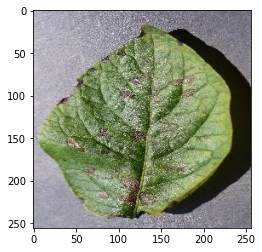

In [63]:
#visualaizing the image, printing only the first image

for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

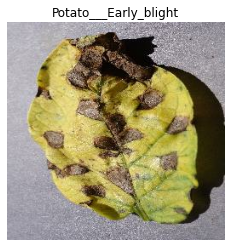

In [10]:
# REMOVING THE AXIS OF THE IMAGE
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

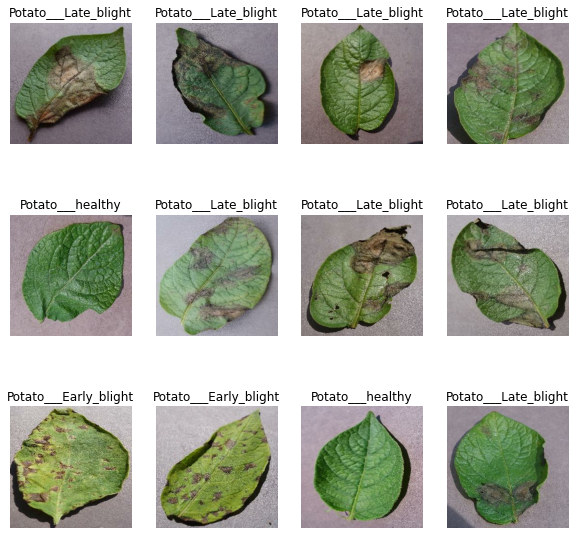

In [64]:
# Displaying first 12 image
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [65]:

len(dataset) #FINDING THE LENGTH OF THE DATASET


68

# FUNCTION TO SPLIT DATASET

In [66]:
# divide the dataset into two;
#80% for training
#20% remaining(10% for validation, 10% for test)

In [67]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [68]:
#FINDING LENGTH OF THE TRAINING DATASET
train_ds=dataset.take(54)
len(train_ds)

54

In [69]:
#skippping first 54 elements
test_ds=dataset.skip(54)
len(test_ds)# LENGTH OF TEST DATASET

14

In [70]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [71]:
#SIZE OF VALIDATION DATA SET
val_ds=test_ds.take(6)
len(val_ds)

6

In [72]:
#SIZE OF TEST DATA SET
test_ds=test_ds.skip(6)
len(test_ds)

8

In [73]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds==ds.skip(train_size).take(val_size)
    return train_ds,val_ds,test_ds
              
                

In [74]:
#train test split
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [126]:
len(train_ds)

54

In [127]:
len(val_ds)

6

In [128]:
len(test_ds)

8

# CACHE, SHUFFLE AND PREFETCH THE DATASET

In [78]:

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# CREATING A LAYER FOR RESIZING AND RESCALING

In [79]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# DATA AUGMENTATION

In [80]:
#inorder to do data preprocessing we are using data augmentation(for a robust model)

data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
                                                    
])


In [81]:
input_shape = (img_size, img_size, CHANNELS)
batch_input_shape = (Batch_size, img_size, img_size, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, img_size, img_size)
    batch_input_shape = (Batch_size, CHANNELS, img_size, img_size)
    chanDim = 1

# CNN ARCHITECTURE

In [83]:
input_shape = (Batch_size, img_size, img_size, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [84]:
model.summary()# FOR DISPLAYING MODEL SUMMARY

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

# COMPILING THE MODEL

In [85]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [86]:
history=model.fit(
train_ds,
epochs=EPOCHS,
batch_size=Batch_size,
verbose=1,
validation_data=val_ds
)

Epoch 1/100
54/54 [==============================] - 78s 1s/step - loss: 0.9384 - accuracy: 0.4902 - val_loss: 0.8853 - val_accuracy: 0.4635
Epoch 2/100
54/54 [==============================] - 70s 1s/step - loss: 0.7400 - accuracy: 0.6586 - val_loss: 0.5107 - val_accuracy: 0.7708
Epoch 3/100
54/54 [==============================] - 78s 1s/step - loss: 0.4399 - accuracy: 0.8218 - val_loss: 0.3251 - val_accuracy: 0.8958
Epoch 4/100
54/54 [==============================] - 85s 2s/step - loss: 0.3573 - accuracy: 0.8559 - val_loss: 0.4484 - val_accuracy: 0.8073
Epoch 5/100
54/54 [==============================] - 84s 2s/step - loss: 0.3191 - accuracy: 0.8779 - val_loss: 0.2457 - val_accuracy: 0.8906
Epoch 6/100
54/54 [==============================] - 88s 2s/step - loss: 0.2471 - accuracy: 0.8906 - val_loss: 0.3358 - val_accuracy: 0.8854
Epoch 7/100
54/54 [==============================] - 91s 2s/step - loss: 0.2100 - accuracy: 0.9161 - val_loss: 0.1907 - val_accuracy: 0.9375
Epoch 8/100
5

54/54 [==============================] - 83s 2s/step - loss: 0.0216 - accuracy: 0.9925 - val_loss: 0.1323 - val_accuracy: 0.9583
Epoch 42/100
54/54 [==============================] - 74s 1s/step - loss: 0.0136 - accuracy: 0.9942 - val_loss: 0.1196 - val_accuracy: 0.9583
Epoch 43/100
54/54 [==============================] - 74s 1s/step - loss: 0.0179 - accuracy: 0.9948 - val_loss: 0.1079 - val_accuracy: 0.9688
Epoch 44/100
54/54 [==============================] - 75s 1s/step - loss: 0.0312 - accuracy: 0.9896 - val_loss: 0.3314 - val_accuracy: 0.9219
Epoch 45/100
54/54 [==============================] - 73s 1s/step - loss: 0.0309 - accuracy: 0.9878 - val_loss: 0.1397 - val_accuracy: 0.9635
Epoch 46/100
54/54 [==============================] - 73s 1s/step - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.5008 - val_accuracy: 0.8438
Epoch 47/100
54/54 [==============================] - 73s 1s/step - loss: 0.0290 - accuracy: 0.9884 - val_loss: 0.2208 - val_accuracy: 0.9375
Epoch 48/100
54/54 

Epoch 99/100
54/54 [==============================] - 82s 2s/step - loss: 0.0045 - accuracy: 0.9983 - val_loss: 0.1164 - val_accuracy: 0.9792
Epoch 100/100
54/54 [==============================] - 86s 2s/step - loss: 0.0078 - accuracy: 0.9971 - val_loss: 0.0124 - val_accuracy: 0.9948


In [87]:
scores = model.evaluate(test_ds)# EVALUATING THE MODEL

8/8 [==============================] - 5s 194ms/step - loss: 0.0566 - accuracy: 0.9914


In [90]:
history.history["accuracy"][-1:]

[0.9971064925193787]

In [91]:
cnn_accuracy=history.history["accuracy"][-1:]# SAVING THE ACCURACY 

# PLOTTING THE ACCURACY AND LOSS CURVES

In [92]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

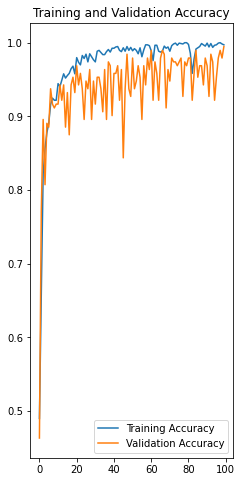

In [93]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

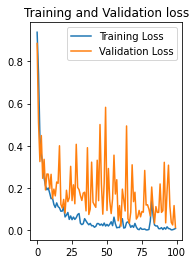

In [94]:
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()


In [45]:
model.save("model1.h5")

In [46]:
# ANN MODEL

# ANN ARCHITECTURE

In [99]:
from tensorflow import keras

# Define your input data and parameters

input_shape = (img_size, img_size, 3)
n_classes = 3
epochs = 100

# Define your model architecture
model = keras.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax'),
])




# COMPILING ANN MODEL

In [100]:
# Compile the model with the desired optimizer, loss function, and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [101]:
# Train the model using training data and validation data
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
54/54 [==============================] - 7s 88ms/step - loss: 1197.3848 - accuracy: 0.4392 - val_loss: 201.0264 - val_accuracy: 0.5417
Epoch 2/100
54/54 [==============================] - 4s 82ms/step - loss: 122.9843 - accuracy: 0.6383 - val_loss: 132.9718 - val_accuracy: 0.5000
Epoch 3/100
54/54 [==============================] - 5s 83ms/step - loss: 69.2173 - accuracy: 0.6840 - val_loss: 14.2994 - val_accuracy: 0.6771
Epoch 4/100
54/54 [==============================] - 5s 85ms/step - loss: 35.1404 - accuracy: 0.7066 - val_loss: 11.5548 - val_accuracy: 0.7865
Epoch 5/100
54/54 [==============================] - 5s 84ms/step - loss: 41.9551 - accuracy: 0.6800 - val_loss: 14.2498 - val_accuracy: 0.7188
Epoch 6/100
54/54 [==============================] - 5s 93ms/step - loss: 18.3330 - accuracy: 0.7523 - val_loss: 19.3830 - val_accuracy: 0.7552
Epoch 7/100
54/54 [==============================] - 5s 98ms/step - loss: 20.4706 - accuracy: 0.7407 - val_loss: 14.8843 - val_accu

Epoch 58/100
54/54 [==============================] - 5s 99ms/step - loss: 0.8915 - accuracy: 0.4549 - val_loss: 0.8637 - val_accuracy: 0.4792
Epoch 59/100
54/54 [==============================] - 5s 101ms/step - loss: 0.8921 - accuracy: 0.4653 - val_loss: 0.8623 - val_accuracy: 0.4792
Epoch 60/100
54/54 [==============================] - 6s 105ms/step - loss: 0.8915 - accuracy: 0.4659 - val_loss: 0.8623 - val_accuracy: 0.4792
Epoch 61/100
54/54 [==============================] - 6s 105ms/step - loss: 0.8910 - accuracy: 0.4774 - val_loss: 0.8633 - val_accuracy: 0.4792
Epoch 62/100
54/54 [==============================] - 6s 104ms/step - loss: 0.8908 - accuracy: 0.4774 - val_loss: 0.8633 - val_accuracy: 0.4792
Epoch 63/100
54/54 [==============================] - 5s 100ms/step - loss: 0.8912 - accuracy: 0.4624 - val_loss: 0.8640 - val_accuracy: 0.4792
Epoch 64/100
54/54 [==============================] - 5s 99ms/step - loss: 0.8909 - accuracy: 0.4653 - val_loss: 0.8632 - val_accuracy: 0

# PLOTTING THE ACCURACY AND LOSS CURVES

In [103]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

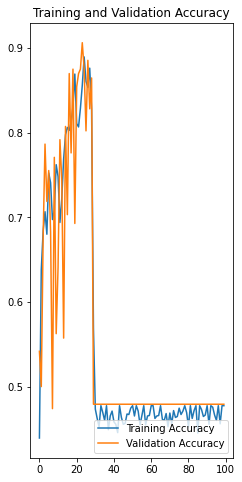

In [104]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

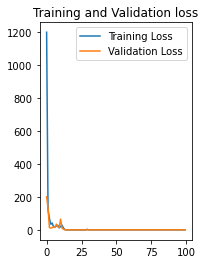

In [105]:
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

In [106]:
history.history["accuracy"][-1:]

[0.4774305522441864]

In [107]:
ann_accuracy=history.history["accuracy"][-1:] # SAVING THE ACCURACY OF ANN MODEL

# ALEXNET ARCHITECTURE

In [108]:
from tensorflow import keras


epochs = 100



model = keras.Sequential([
    keras.layers.Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(img_size,img_size,3)),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(256, (5,5), activation='relu', padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(384, (3,3), activation='relu', padding="same"),
    keras.layers.Conv2D(384, (3,3), activation='relu', padding="same"),
    keras.layers.Conv2D(256, (3,3), activation='relu', padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(n_classes, activation='softmax')
])





# COMPILING THE MODEL

In [109]:
# Compile the model with adam optimizer, loss function, and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [110]:
# Train the model using training data and validation data
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)


Epoch 1/100
54/54 [==============================] - 100s 2s/step - loss: 27.8469 - accuracy: 0.4601 - val_loss: 0.8494 - val_accuracy: 0.6719
Epoch 2/100
54/54 [==============================] - 106s 2s/step - loss: 0.8597 - accuracy: 0.5845 - val_loss: 0.9038 - val_accuracy: 0.5885
Epoch 3/100
54/54 [==============================] - 113s 2s/step - loss: 0.9419 - accuracy: 0.5231 - val_loss: 0.8952 - val_accuracy: 0.4635
Epoch 4/100
54/54 [==============================] - 112s 2s/step - loss: 0.8992 - accuracy: 0.5162 - val_loss: 0.8296 - val_accuracy: 0.6302
Epoch 5/100
54/54 [==============================] - 113s 2s/step - loss: 0.7535 - accuracy: 0.6644 - val_loss: 0.6012 - val_accuracy: 0.7604
Epoch 6/100
54/54 [==============================] - 114s 2s/step - loss: 0.5616 - accuracy: 0.7940 - val_loss: 0.3922 - val_accuracy: 0.8750
Epoch 7/100
54/54 [==============================] - 115s 2s/step - loss: 0.4378 - accuracy: 0.8235 - val_loss: 0.4960 - val_accuracy: 0.7812
Epoch

54/54 [==============================] - 114s 2s/step - loss: 0.0387 - accuracy: 0.9850 - val_loss: 0.0605 - val_accuracy: 0.9740
Epoch 59/100
54/54 [==============================] - 116s 2s/step - loss: 0.0316 - accuracy: 0.9902 - val_loss: 0.2856 - val_accuracy: 0.9219
Epoch 60/100
54/54 [==============================] - 115s 2s/step - loss: 0.1080 - accuracy: 0.9664 - val_loss: 0.0512 - val_accuracy: 0.9792
Epoch 61/100
54/54 [==============================] - 111s 2s/step - loss: 0.1046 - accuracy: 0.9699 - val_loss: 0.1768 - val_accuracy: 0.9375
Epoch 62/100
54/54 [==============================] - 120s 2s/step - loss: 0.0997 - accuracy: 0.9635 - val_loss: 0.0665 - val_accuracy: 0.9688
Epoch 63/100
54/54 [==============================] - 114s 2s/step - loss: 0.0274 - accuracy: 0.9896 - val_loss: 0.0553 - val_accuracy: 0.9844
Epoch 64/100
54/54 [==============================] - 110s 2s/step - loss: 0.0329 - accuracy: 0.9884 - val_loss: 0.1065 - val_accuracy: 0.9688
Epoch 65/100

In [113]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

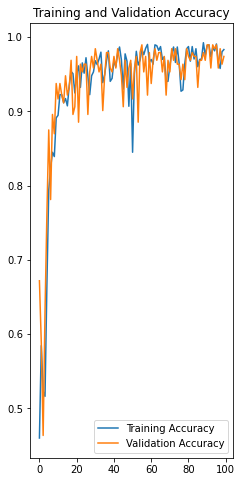

In [114]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

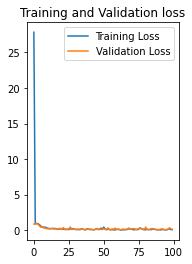

In [115]:
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()


In [116]:
history.history["accuracy"][-1:]

[0.9832175970077515]

In [117]:
AlexNet_accuracy=history.history["accuracy"][-1:]

In [ ]:
# PRINTING MODEL ACCURACIES

In [118]:
print(AlexNet_accuracy) 

[0.9832175970077515]


In [119]:
print(ann_accuracy)

[0.4774305522441864]


In [120]:
print(cnn_accuracy)

[0.9971064925193787]


# MODEL SELECTION

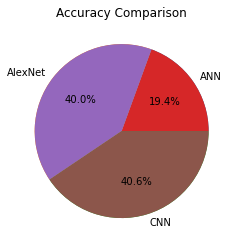

CNN has the highest accuracy with [0.9971064925193787] %


In [130]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array([ann_accuracy, AlexNet_accuracy, cnn_accuracy])
y = y.flatten()  # reshape to one-dimensional array
plt.pie(y)

# Create labels for the pie chart
labels = ['ANN', 'AlexNet', 'CNN']

# Create a pie chart with labels and percentage values
plt.pie(y, labels=labels, autopct='%1.1f%%')

# Add a title to the pie chart
plt.title('Accuracy Comparison')

# Display the pie chart
plt.show()

# Comparing the accuracy values

if cnn_accuracy > ann_accuracy and cnn_accuracy > AlexNet_accuracy:
    print("CNN has the highest accuracy with", cnn_accuracy, "%")
elif AlexNet_accuracy > ann_accuracy:
    print("AlexNet has the highest accuracy with", AlexNet_accuracy, "%")
else:
    print("ANN has the highest accuracy with", ann_accuracy, "%")
    


# INFERENCES ON NEW EXAMPLES

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 788ms/step
predicted label: Potato___Early_blight


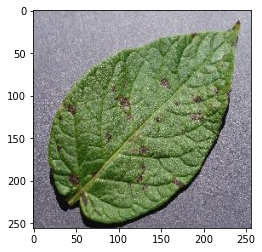

In [122]:
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [123]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) # Create a batch
    
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2) # CHECKING CONFIDENCE OF PREDICTIONS
    return predicted_class,confidence

1/1 [==============================] - 0s 104ms/step


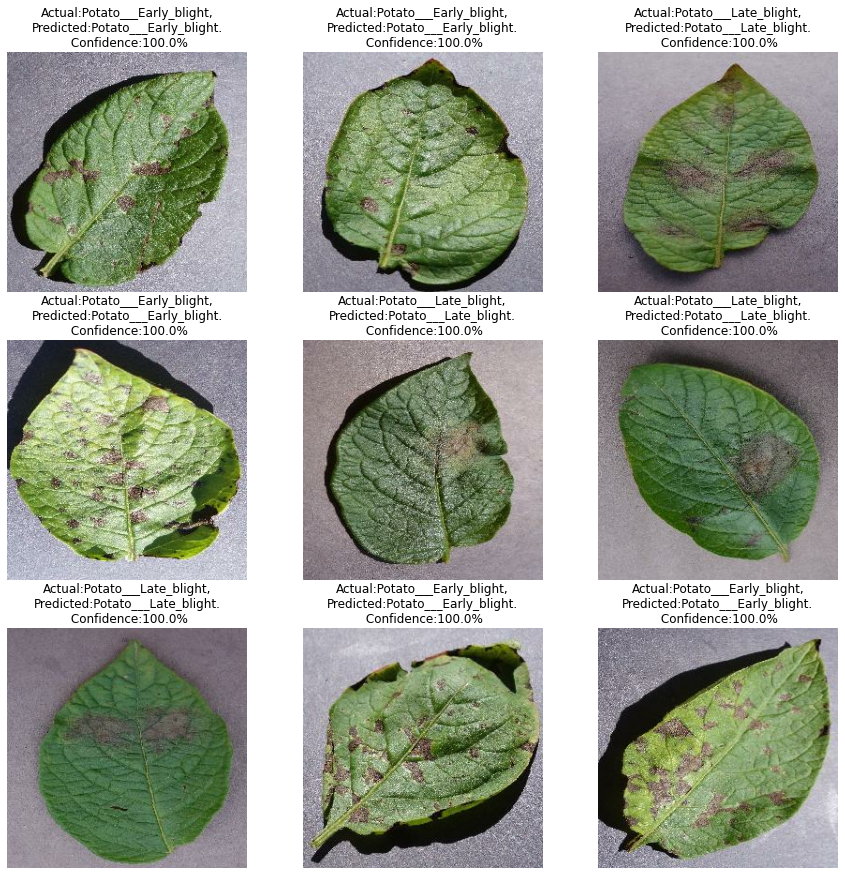

In [129]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\nPredicted:{predicted_class}.\n Confidence:{confidence}%")
        plt.axis("off")